In [ ]:
import re
from typing import List, Tuple

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText
import umap
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, tokenize_document, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 12)})

In [ ]:
dataset = read_lang_dataset('data/dataset_github_codes.db')
dataset

In [ ]:
dataset.language.value_counts()

In [ ]:
use_cache = True
# load "tokenized_sample.pkl" from disk if it exists
if use_cache and os.path.exists("models/tokenized_sample.pkl"):
    tokenized_sample = pd.read_pickle("models/tokenized_sample.pkl")
else:
    tokenized_sample = tokenize_dataset(dataset)
    tokenized_sample.to_pickle("models/tokenized_sample.pkl")

tokenized_sample

In [4]:
common_keywords = ["if", "else", "for", "while", "class", "struct", "return", "continue", "break", "var", "try", "catch", "except"]
semantic_symbols = ["{", "}", ":"]

language_specific_words = common_keywords + semantic_symbols

In [5]:
from functools import partial


def add_language_prefix(code, language):
    return [f"{language}_{keyword}" if keyword in language_specific_words else keyword for keyword in code]

for language in tokenized_sample.language.unique():
    tokenized_sample.loc[tokenized_sample.language == language, "code"] = tokenized_sample[tokenized_sample.language == language].code.apply(partial(add_language_prefix, language=language))

In [21]:
complete_model = Word2Vec(vector_size=200, window=5, min_count=10, workers=8)
#complete_model = FastText(vector_size=100, window=5, min_count=10, workers=8)
complete_model.build_vocab(tokenized_sample.code)
complete_model.train(tokenized_sample.code, total_examples=complete_model.corpus_count, epochs=5)
complete_model

# Visualize

In [22]:
inserted_tokens = ["INT_LITERAL", "FLOAT_LITERAL", "STRING_LITERAL", "VARIABLE"]
math_ops = ["+", "-", "*", "/", "%", "&&", "||", "!", "&", "|"]

python_keywords = ["def", "class", "return", "if", "else", "for", "while", "in", "import", "from", "as", "with", "try", "except", "finally", "raise", "assert", "yield", "lambda", "pass", "break", "continue", "del", "global", "nonlocal", "and", "or", "not", "is", "in", "True", "False", "None", "async", "await"]
cpp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
csharp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
go_keywords = ["break", "func", "default", "type", "defer", "go", "struct", "map", "chan", "else", "goto", "package", "range", "const", "fallthrough", "for", "import", "interface", "return", "select", "case", "continue", "if", "switch", "var", "nil", "true", "false"]

In [23]:
def word_cloud(model: Word2Vec, words):
    words = [word for word in words if word in model.wv.key_to_index.keys()]
    word_vectors = np.array([model.wv.get_normed_vectors()[model.wv.key_to_index[word]] for word in words])
    reducer = umap.UMAP() #PCA(n_components=2)
    result = reducer.fit_transform(word_vectors)

    df = pd.DataFrame(result, columns=["x", "y"])
    df["model"] = [word.split("_")[0] if len(word.split("_")) == 2 else "" for word in words]
    ax = sns.scatterplot(data=df, x="x", y="y", hue="model", s=100)
    range_x, range_y = np.ptp(df[["x", "y"]], axis=0)
    keywords = [word.split("_")[1] if len(word.split("_")) == 2 else word for word in words]
    for i, word in enumerate(keywords):
        x, y = result[i]
        ax.text(x + 0.005 * range_x, y, word, verticalalignment='center', horizontalalignment='left', fontsize=14)
    return ax

<AxesSubplot: xlabel='x', ylabel='y'>

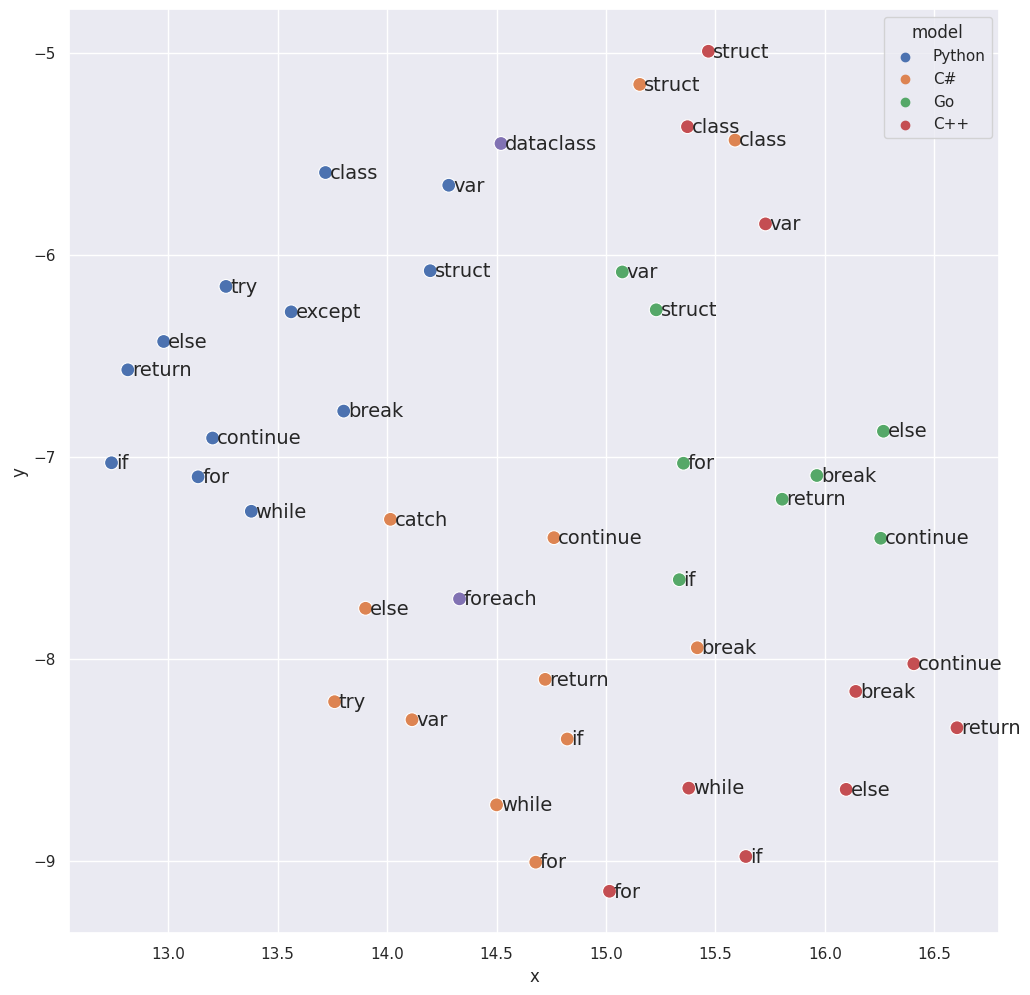

In [25]:
word_cloud(complete_model, [f"{language}_{w}" for w in common_keywords for language in tokenized_sample.language.unique()] + ["foreach", 'dataclass'])

In [26]:
python_codes = tokenized_sample[tokenized_sample["language"] == 'Python']

python_model = Word2Vec(vector_size=200, window=5, min_count=10, workers=8, sg=1)
python_model.build_vocab(python_codes.code)
python_model.train(python_codes.code, total_examples=python_model.corpus_count, epochs=5)
python_model

In [27]:
python_code_example = """#!/usr/bin/env python3

import os

def main():
    query = 7
    context = [3, 4, 10, 2, 8, 6, 5, 9, 7, 1]
    for i in range(len(context)):
        if context[i] == query:
            print(f'Query found at index {i}')
            os.exit(0)    

    print(f'Coulnd't find query {query}')
    os.exit(-1)


if __name__ == '__main__':
    main()

}"""

tokenized_code_example = tokenize_document(python_code_example, "Python")
tokenized_code_example = add_language_prefix(tokenized_code_example, "Python")
for word in tokenized_code_example:
    print(f' {word}', end="")

def next_similar_token(token: str) -> str:
    next_most_similar_token, _ = complete_model.wv.most_similar(positive=[token])[0]
    return next_most_similar_token

print('-' * 20)

next_similar_document = ' '.join([next_similar_token(t) for t in tokenized_code_example])
next_similar_document = next_similar_document.replace(':', ':\n')
print(next_similar_document)


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


 
 import os 
 def main ( ) Python_:        VARIABLE = FLOAT_LITERAL   VARIABLE = [ FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL ]   Python_for i in range ( len ( VARIABLE ) ) Python_:            Python_if VARIABLE [ i ] == VARIABLE Python_:                print ( STRING_LITERAL )   os . exit ( FLOAT_LITERAL )       VARIABLE ( STRING_LITERAL VARIABLE VARIABLE VARIABLE Python_{ VARIABLE Python_}   os . exit ( - FLOAT_LITERAL ) 
 
 Python_if __name__ == STRING_LITERAL Python_:        main ( ) 
 
 <EOF>--------------------


 package _os 

 super unittest VARIABLE VARIABLE   Python_:
     ) VARIABLE   Python_:
 ) VARIABLE pn   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   STRING_LITERAL   quote Python_:
 enumerate j startswith enumerate VARIABLE RestartCount VARIABLE ) VARIABLE VARIABLE   

In [28]:
recent_tokens = ['import', 'os']

for i in range(20):
    next_tokens = python_model.predict_output_word(recent_tokens[-5:])

    token_found = False
    for t, _ in next_tokens:
        if t in recent_tokens[-5:] and t not in ['import', ',']:
            continue

        recent_tokens.append(t)
        print(t, end=' ')
        token_found = True

    if not token_found:
        t, _ = next_tokens[0]
        recent_tokens.append(t)
        print(t, end=' ')


shutil system re import random bs4 pathlib threading Common requests import from urllib base64 
 uuid concurrent bs4 futures urllib 
 base64 import uuid rich requests bs4 futures concurrent base64 import requests ThreadPoolExecutor urllib uuid bs4 concurrent futures import sop base64 rich bs4 ThreadPoolExecutor as from import BeautifulSoup bs4 rich futures as concurrent import from sop rich futures concurrent bs4 ThreadPoolExecutor BeautifulSoup as from import bs4 rich BeautifulSoup futures as concurrent import from sop rich futures concurrent bs4 ThreadPoolExecutor BeautifulSoup as from import bs4 rich BeautifulSoup futures as concurrent import from sop rich futures concurrent bs4 ThreadPoolExecutor BeautifulSoup as from import bs4 rich BeautifulSoup futures as concurrent import from sop rich futures concurrent bs4 ThreadPoolExecutor BeautifulSoup as from import bs4 rich BeautifulSoup futures as concurrent import from sop rich futures concurrent bs4 ThreadPoolExecutor BeautifulSoup as

Number to different tokens: 36150
10 most frequent tokens for Python:
 VARIABLE: 524241
 ,: 337469
 STRING_LITERAL: 315775
 .: 306763
  : 298737
 (: 271330
 ): 269726
 =: 177147
 Python_:: 151609
 FLOAT_LITERAL: 77898
Number to different tokens: 46677
10 most frequent tokens for C#:
 .: 337464
 VARIABLE: 282619
 (: 227667
 ): 227622
 ;: 210292
 ,: 118142
 =: 102123
 C#_{: 90397
 C#_}: 88813
 STRING_LITERAL: 70338
Number to different tokens: 31247
10 most frequent tokens for Go:
 VARIABLE: 577861
 ,: 491687
 .: 407431
 (: 342090
 ): 342053
 
: 260226
 STRING_LITERAL: 185375
 INT_LITERAL: 166587
 Go_{: 147162
 Go_}: 147109
Number to different tokens: 51581
10 most frequent tokens for C++:
 VARIABLE: 527661
 ,: 362480
 ;: 362319
 (: 348119
 ): 347616
 INT_LITERAL: 146625
 ->: 124351
 *: 122931
 =: 116561
 C++_{: 90082


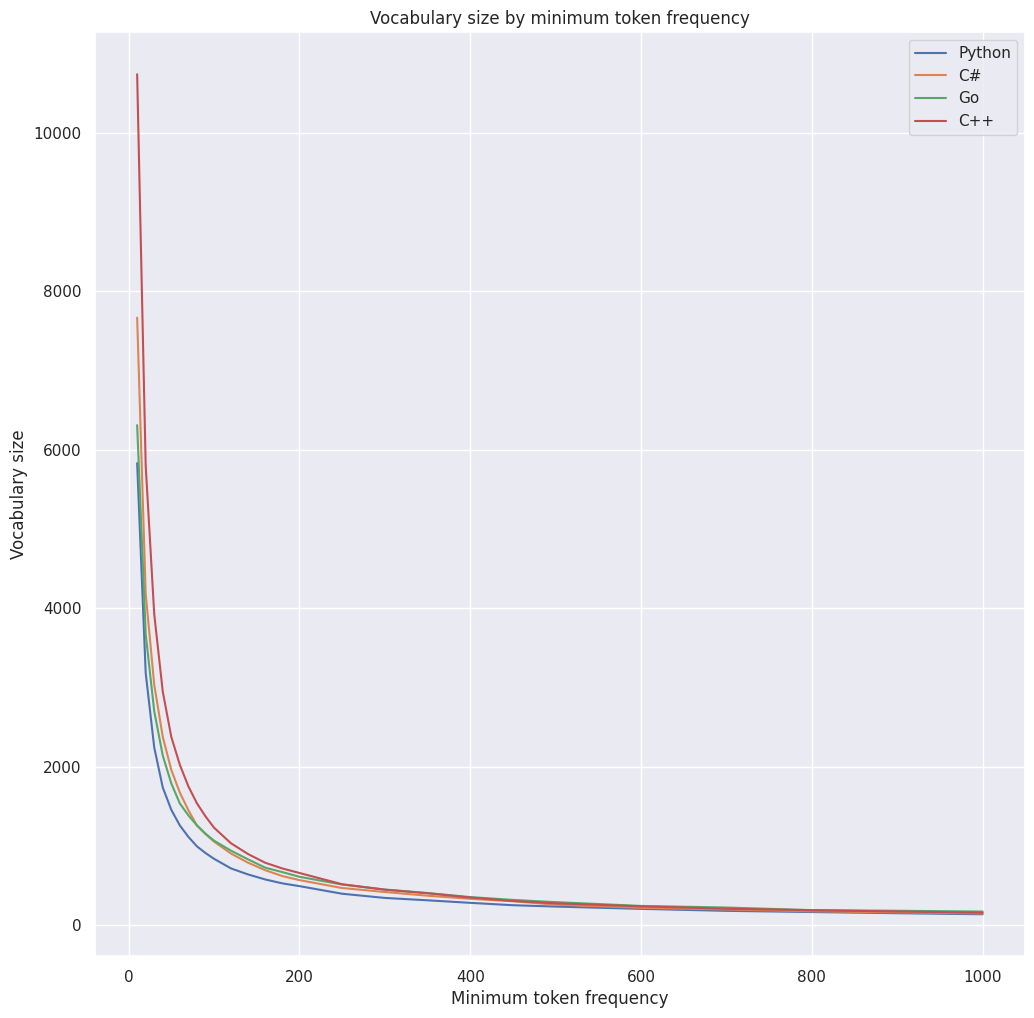

In [29]:
most_frequent_tokens = {}
for language in tokenized_sample.language.unique():
    code_for_language = tokenized_sample[tokenized_sample["language"] == language]
    token_frequency = {}
    for code in code_for_language.code:
        for token in code:
            token_frequency[token] = token_frequency.get(token, 0) + 1
    print(f'Number to different tokens: {len(token_frequency)}')

    token_frequency_sorted = sorted(token_frequency.items(), key=lambda x: x[1], reverse=True)
    most_frequent_tokens[language] = token_frequency_sorted[0:3]
    print(f'10 most frequent tokens for {language}:')
    for token, freq in token_frequency_sorted[:10]:
        print(f' {token}: {freq}')

    token_frequency_meta = {}
    for m in [10,20,30,40,50,60,70,80,90,100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]:
        for token, freq in token_frequency.items():
            if freq >= m:
                token_frequency_meta[m] = token_frequency_meta.get(m, 0) + 1
    plt.plot(list(token_frequency_meta.keys()), list(token_frequency_meta.values()), label=language)

plt.title('Vocabulary size by minimum token frequency')
plt.xlabel('Minimum token frequency')
plt.ylabel('Vocabulary size')
plt.legend()
plt.show()

In [33]:
complete_model.wv.most_similar(positive=['C++_if'], negative=['Python_if'])


[('C++_while', 0.4614696800708771),
 ('NULL', 0.45895281434059143),
 ('Equal', 0.36967045068740845),
 ('ASSERT', 0.35357555747032166),
 ('WARN_ON_ONCE', 0.35097357630729675),
 ('EXAMPLE_BUFF_SIZE', 0.3378746807575226),
 ('cpage_count', 0.33654484152793884),
 ('BeNil', 0.33325543999671936),
 ('WARN_ONCE', 0.32710522413253784),
 ('sizeof', 0.3178255259990692)]

In [31]:
average_token_length = {}
for language in tokenized_sample.language.unique():
    code_for_language = tokenized_sample[tokenized_sample["language"] == language].code
    
    # get average code length for all elements in code_for_language rounded to 2 decimals
    code_lengths = [len(code) for code in code_for_language]
    average_token_length[language] = round(sum(code_lengths) / len(code_lengths), 2)

In [32]:
print('|    | C++ | Go | C# | Python |')
print('|---|---|---|---|---|')
print(f'| Avg. tokens per file | {average_token_length["C++"]} | {average_token_length["Go"]} | {average_token_length["C#"]} | {average_token_length["Python"]} |')
print(f'| Most frequent token | {most_frequent_tokens["C++"][0][0]} | {most_frequent_tokens["Go"][0][0]} | {most_frequent_tokens["C#"][0][0]} | {most_frequent_tokens["Python"][0][0]} |')
print(f'| 2nd most frequent token | {most_frequent_tokens["C++"][1][0]} | {most_frequent_tokens["Go"][1][0]} | {most_frequent_tokens["C#"][1][0]} | {most_frequent_tokens["Python"][1][0]} |')
print(f'| 3rd most frequent token | {most_frequent_tokens["C++"][2][0]} | {most_frequent_tokens["Go"][2][0]} | {most_frequent_tokens["C#"][2][0]} | {most_frequent_tokens["Python"][2][0]} |')
print(f'| Number of keywords | 95 | 25 | 79 | 33 |')

|    | C++ | Go | C# | Python |
|---|---|---|---|---|
| Avg. tokens per file | 1545.66 | 2136.9 | 1218.43 | 1889.92 |
| Most frequent token | VARIABLE | VARIABLE | . | VARIABLE |
| 2nd most frequent token | , | , | VARIABLE | , |
| 3rd most frequent token | ; | . | ( | STRING_LITERAL |
| Number of keywords | 95 | 25 | 79 | 33 |


|    | C++ | Go | C# | Python |
|---|---|---|---|---|
| Avg. tokens per file | 1545.66 | 2136.9 | 1218.43 | 1889.92 |
| Most frequent token | VARIABLE | VARIABLE | . | VARIABLE |
| 2nd most frequent token | , | , | VARIABLE | , |
| 3rd most frequent token | ; | . | ( | STRING_LITERAL |
| Number of keywords | 95 | 25 | 79 | 33 |